<a href="https://colab.research.google.com/github/jsaroni/QHack2023_Feynmanprodigies/blob/main/final_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QHack2022 Open Hackathon - FEYNMAN PRODIGIES TEAM




Project Name: Efficient ground state computation methodologies for BeH2




In this notebook, we describe the implementation of different methodologies to find the ground state of the molecule BeH2, each with their own merits and drawbacks. The methods used consider only single and double excitations. Some of the methodologies that we implement greatly simplify the model while sacrificing chemical accuracy while others use error mitigation more efficiently through qiskit runtime which works well with hybrid algorithms such as VQE.


We are trying to find the ground state of BeH2, so it is worth knowing more on its physical chemistry. Beryllium has chemical formula 1s2 2s2 and the two hydrogens 1s1 in electron configuration notation. When the molecule BeH2 is formed, the s orbitals from the two hydrogens hybridize with the p orbitals from beryllium to form two sp molecular orbital bonds that want to be as far away from each other as possible due to electron repulsion and this results in a linear molecule. We use the sto3g basis to approximate slater type orbitals.

The following module need installation: qiskit for testing our quantum simulations, pyscf as an open source collection of electronic structure modules, qiskit_nature, and qiskit_ibm_runtime.

In [ ]:
#Install the required packages
'''
!pip install qiskit
!pip install pennylane
!pip install qiskit_nature
!pip install scipy
!pip install pyscf
!pip install qiskit_ibm_runtime
'''


In [ ]:
#Load the required packages
import pennylane.numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA


from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

VQE

First we do the usual hybrid VQE algorithm using single and double excitations UCCSD strategy. We use all such excitations to come up with the ground state energy calculation. 

For this setup we use 4 electrons in 6 orbitals inside the molecule. The pair of electrons in the 1s orbital(core) of Be atom are stable, therefore we don't include them in our active space. We use the sto-3g basis set and two-qubit reduction method using parity mapping to reduce the system size without affecting the calculation due to symmetry. We first find the true ground state energy which we will use throughout the file for reference, as the target. Note that this is calculated using NumpyEigenSolver. 

We then make a circuit and find the expected value of the hamiltonian using ADAM optimizer. 

We calculate the time taken for this method, along with the number of CNOT gates that are in the circuit. This number is calculated using the formula 13 x double_excitations + 2 x single_excitations. This is because of the number of CNOT gates using in the ansatz for the respective excitation schemes. Finally we plot the graph of the GS Energy calculation over time.

In [ ]:
# Coordinates(val) are given in Angstrom
val = 1.291
Beh2 = [["Be", [0.0, 0.0, 0.0]],
        ["H", [-val, 0.0, 0.0]], 
        ["H", [val, 0.0, 0.0]]]
#define the molecule using qiskit_nature.drivers        
BeH2 = Molecule( 
    geometry=Beh2 , # The coordinates
    multiplicity=1, # 2*S + 1
    charge=0,
)
#define driver using qiskit_nature.drivers.second_quantization
driver = ElectronicStructureMoleculeDriver(BeH2, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()

In [ ]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

In [ ]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")


#Now we remove/freeze the core orbital 1s of Be for the calculations
# Define the active space around the Fermi level 
transformer = ActiveSpaceTransformer(
    num_electrons=4, # Number of electrons in our active space
    num_molecular_orbitals=6, # Number of orbitals in our active space
)

# Now we can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [ ]:
#Using paritymapper to take advantage of the Z2 symmetry of the system
mapper = ParityMapper()

converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
#reduces the qubit number by 2
parity_converter = QubitConverter(mapper, two_qubit_reduction=True)    

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

In [ ]:
#Use UCCSD ansatz to look for single and double excitation on noiseless simulator
vqe_factory = VQEUCCFactory( 
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(maxiter=6,ftol = 1e-4),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

#Find the real solution using classical method
solver = GroundStateEigensolver(parity_converter, vqe_factory) 
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

In [ ]:
symbols = ["H","Be","H"]
geometry = np.array([ -1.291/0.529, 0.0, 0.0,0.0, 0.0, 0.0, 1.291/0.529, 0.0, 0.0])
#define the hamiltonian of the system
hamil = qml.qchem.molecular_hamiltonian(symbols,geometry,charge = 0,basis = 'sto-3g', active_electrons=4, active_orbitals=6)[0]
#number of qubits
n_qubits = len(hamil.wires)

#define the hf state
hf_state = qml.qchem.hf_state(electrons=4, orbitals=n_qubits)
# singles and doubles are used to make the AllSinglesDoubles template
singles, doubles = qml.qchem.excitations(4, n_qubits)

In [ ]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 10



dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)


def cost(weights):
    qml.BasisState(hf_state, wires=list(range(n_qubits)))
    for i in range(len(singles)):            
        qml.SingleExcitation(weights[i+len(doubles)], wires=singles[i])
    for i in range(len(doubles)):
        qml.DoubleExcitation(weights[i], wires=doubles[i])        
    return qml.expval(hamil)

weights =np.zeros(len(doubles + singles), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.05)
i=0
iter=[]
cost_val=[]
Lowest_E=0
best_weights=0
for _ in range(30):
    weights = opt.step(cost, weights)
    iter.append(i)
    cost_fn=cost(weights)
    if Lowest_E>cost_fn:
        Lowest_E=cost_fn
        best_weights=weights
    cost_val.append(cost_fn)
    print('iter:',i,' cost_fn:',cost_fn)
    i=i+1

In [ ]:
#Total number of 2-qubit (CNOT) gates
print("Total number of CNOT gates used = ", 13*len(doubles) + 2*len(singles)) 

In [ ]:
# The following plot is of full VQE
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(cost_val, label="Estimator VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

ADAPT_VQE

In the previous calculation, we used all the single and double excitations, however, one can reduce their number by looking at the gradient w.r.t. parameters for those schemes. The idea is that if the parameters remain constant, then we can train the schemes where parameters need to change in order to reduce the time as well as the number of gates required.

The same is demonstrated using ADAPT_VQE, where we 'ADAPT' to non-vanishing gradients and using a similar ansatz with restricted number of schemes, we get much faster and better results. This is basically due to the classical preprocessing of data.

The convergence can be seen after merely 10 iterations and the time taken is less than a minute for optimization. The number of CNOT gates already reduce by a factor of 10.

In [ ]:
#We use pennylane for faster computation

#Define the symbol and geometry
symbols = ["H","Be","H"]
#Geometry in atomic distance for pennylane
geometry = np.array([ -1.291/0.529, 0.0, 0.0,0.0, 0.0, 0.0, 1.291/0.529, 0.0, 0.0])
active_electrons = 4
H, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    geometry,
    active_electrons=active_electrons,
    active_orbitals=6
)

print(f"Total number of excitations = {len(singles) + len(doubles)}")

In [ ]:


def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)
dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev)

circuit_gradient = qml.grad(cost_fn, argnum=0)

params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)

In [ ]:
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.5)

params_doubles = np.zeros(len(doubles_select), requires_grad=True)

for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)
cost_fn = qml.QNode(circuit_2, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)

grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)

In [ ]:
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5 ]

In [ ]:
cost_fn = qml.QNode(circuit_1, dev)

params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

gates_select = doubles_select + singles_select
energy_vals = []
import time
for n in range(20):
    t1 = time.time()
    params, energy = opt.step_and_cost(cost_fn, params, excitations=gates_select)
    t2 = time.time()
    energy_vals.append(energy)
    print("n = {:},  E = {:.8f} H, t = {:.2f} s".format(n, energy, t2 - t1))

In [ ]:
#Total number of 2 qubit gates used
print('Total number of CNOT qubit gates used =', 13*len(doubles_select) + 2*len(singles_select))

In [ ]:
# The following plot is of ADAPT_VQE
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(energy_vals, label="ADAPT VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

TETRIS_VQE

TETRIS_VQE is a dynamic circuit design based on the idea of ADAPT VQE. 

Instead of using the same number of gates to begin with, the idea is to keep adding gates until we converge. We start with some scheme with non-zero gradient sorted in an order. We run the optimization method for that fixed circuit and calulcate the GS Energy. After each iteration, we add more schemes from the bigger pool in a constrained manner.

In this work, we look at the closeness to the actual solution. By this, we mean that we stop if the GS Energy we get after dynamic addition of schemes to circuits is close to the real energy calculated above. Another method could be to use the different in the energy values and decide convergence on that. 

This method could be useful for large circuits where the number of schemes is large so that a step by step addition results in a better convergence. 

In our code, we get the convergence we want, with time and CNOT gates in between VQE and ADAPT VQE.

In [ ]:

#Define the symbol and geometry
symbols = ["H","Be","H"]
#Geometry in atomic distance for pennylane
geometry = np.array([ -1.291/0.529, 0.0, 0.0,0.0, 0.0, 0.0, 1.291/0.529, 0.0, 0.0])
active_electrons = 4
H, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    geometry,
    charge = 0,
    active_electrons=active_electrons,
    basis = 'sto-3g',
    active_orbitals=6
)
n_qubits = qubits
#HF State
hf_state= qml.qchem.hf_state(electrons=active_electrons, orbitals=n_qubits)


#all the operators together
all_operators=singles+doubles

params = [0.0] * len(doubles+singles)
params=np.array(params )

#define the circuit again
def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(n_qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(H )

    
    
dev = qml.device("default.qubit", wires=n_qubits)
cost_fn = qml.QNode(circuit_1, dev)
circuit_gradient = qml.grad(cost_fn, argnum=0)
grads = circuit_gradient(params, excitations=doubles+singles)

#operators in the opposite manner
opposite_pool=doubles+singles

#Thresholding the excitations
new_opposite_pool=[opposite_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
#gradients for the excitations thresholded
new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]
   
#Now we sort these gradients and we will apply it sequentially
indx=np.argsort(np.abs(new_grads))
sorted_opposite_pool=[new_opposite_pool[idx] for idx in indx]

#For the shallower circuit, we will use this
shallow_circuits=[]    
while len(sorted_opposite_pool) !=0:
    q_layer=[]     
    ind_left=[]  
    for idx, op in enumerate(sorted_opposite_pool):
        if shallow_circuits==[]:
            shallow_circuits.append(op)
            q_layer=q_layer+op
        else:
            Stack=True
            for k in op:
                if k in q_layer:
                    Stack=False
                    ind_left.append(idx)
                    break
            if Stack:
                shallow_circuits.append(op)
                q_layer=q_layer+op
    sorted_opposite_pool=[sorted_opposite_pool[idx] for idx in ind_left]

params = [0.0] * len(doubles_select+singles_select)
params=np.array(params )

q_layer=[]
time_iterations=20
conv_tol=1e-4
energy=[]

opt = qml.GradientDescentOptimizer(stepsize=0.3) 
dev = qml.device("default.qubit", wires=n_qubits)

cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
circuit_gradient = qml.grad(cost_fn, argnum=0) # step 2.

energy = [cost_fn(params, shallow_circuits)] # step 2.
print(f"time_iteration = 0,  Energy = {energy[-1]:.8f} Ha")
print("Number of gates = {}\n".format(len(shallow_circuits)))
configs=qml.specs(cost_fn)(params, excitations=shallow_circuits)
print("Circuit Depth = {}\n".format(configs['depth'],))
t1 = time.time()
for n in range(time_iterations):

    Test_set=shallow_circuits+all_operators
    Test_parameters=list(params)+[0.0]*len(all_operators)
    Test_parameters=np.array(Test_parameters)
        
    test_grads = circuit_gradient(Test_parameters,Test_set)
    test_grads = test_grads[len(params):]

    test_sorted_indx=np.argsort(np.abs(test_grads))[::-1]
    maxpos=test_sorted_indx[0]
    Larger_sorted_indx=[]
    for ind in test_sorted_indx:
        Larger_sorted_indx.append(ind)

    for k,ind in enumerate(Larger_sorted_indx):
        op_set=set(all_operators[ind])
        q_layer_set=set(q_layer)
        if not bool(op_set & q_layer_set):
            q_layer=q_layer+all_operators[ind]
            shallow_circuits.append(all_operators[ind])
            params=np.append(params, 0.0)
        if (len(q_layer)>=n_qubits-4): # It is hard to find the operators with non-zero gradient fill all qubit layers.
            q_layer=[]                                 # We leave at maximum 4 idle qubits
            break


    params,_ = opt.step(cost_fn, params, shallow_circuits) # Step 5.
    E_val=cost_fn(params, shallow_circuits)
    energy.append(E_val)
    conv = np.abs(real_solution_t.real - E_val) #step 3.

    print(f"time_iteration = {n+1}, Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(shallow_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=shallow_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))
    if conv <= conv_tol:
        break
t2 = time.time()

In [ ]:
# The following plot is of ADAPT_VQE
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(energy, label="TETRIS ADAPT VQE BeH2 IDEAL")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("TETRIS ADAPT VQE energy")
plt.show()

In [ ]:
num_two_gates = 0
for ele in shallow_circuits:
    if len(ele)==2:
        num_two_gates+=2
    else:
        num_two_gates+=13
print('Number of two qubit CNOT gates for TETRIS ADAPT VQE is', num_two_gates)

In [ ]:
print('Time taken =', t2-t1)

Plotting the three different techniques overlaid on each other for comparison

In [ ]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(cost_val[:20], label="VQE")
plt.plot(energy_vals, label="ADAPT_VQE")
plt.plot(energy, label="TETRIS_ADAPT_VQE")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

So far we used hybrid algorithm VQE with different techniques to get estimates on a noiseless (simulated) quantum backend. However, on real quantum devices, the errors propagate pretty fast. Therefore, we need error mitigation techniques. 

Furthermore, we need to apply it to systems where the number of two qubit gates (most prone to error after toffoli) are minimized. To resolve this issue, we look at a smaller system

Now using error mitigation with qiskit runtime and just VQE. This method is based on a crude approximation, restricting the Hilbert space to an active space of unbonded electrons within the BeH2 molecule.. The circuits take longer to run depending on how available the ibm backend is but achieve error mitigated results.

In [ ]:
#Load the required packages
import pennylane.numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA


from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

We use the linear geometry of the molecule and set a distance d as rougly the equilibrium distance of the two hydrogen atoms from beryllium which is 1.29 Angstroms.

In [ ]:
#### Fill in the values below and complete the function to define the Molecule ####
d = 1.291
# Coordinates are given in Angstrom
# Replace BeH2 with appropriate molecule
beh2 = [["Be", [0, 0.0, 0.0]], 
              ["H", [-d, 0.0, 0.0]],
              ["H", [d, 0.0, 0.0]]]
                  
BeH2 = Molecule( 
    geometry= beh2,  
    multiplicity= 1, 
    charge= 0, 
)

driver = ElectronicStructureMoleculeDriver(BeH2, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) 

properties = driver.run()

In [ ]:
num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
num_beta_electrons = properties.get_property('ParticleNumber').num_beta
num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
print("number of alpha electrons: " , num_alpha_electrons)
print("number of beta electrons: " , num_beta_electrons)
print("number of spin orbitals: " , num_spin_orbitals)
print("nuclear repulsion energy: " , nuclear_rep_energy)

In [ ]:
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space around the Fermi level 
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=2, # Number of electrons in our active space
    num_molecular_orbitals=2, # Number of orbitals in our active space
)

# Now you can get the reduced electronic structure problem
problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

# The second quantized Hamiltonian of the reduce problem
second_q_ops_reduced = problem_reduced.second_q_ops()

In [ ]:
# Setup the mapper and qubit converter
mapper_type = 'ParityMapper'

if mapper_type == 'ParityMapper':
    mapper = ParityMapper()
elif mapper_type == 'JordanWignerMapper':
    mapper = JordanWignerMapper()
elif mapper_type == 'BravyiKitaevMapper':
    mapper = BravyiKitaevMapper()


converter = QubitConverter(mapper)

qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])

In [ ]:
# Set the mapper to qubits
parity_mapper = ParityMapper() 

# Set the qubit converter with two qubit reduction to reduce the computational cost 
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)    

# Compute the Hamitonian in qubit form
qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)

In [ ]:
vqe_factory = VQEUCCFactory( # This is an example of UCC"SD" ansatz
    quantum_instance=Aer.get_backend("aer_simulator_statevector"),
    optimizer=SLSQP(),
    ansatz=UCC(excitations='sd')
) 

from qiskit.algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(parity_converter, vqe_factory)  # Define Numpy
real_solution_t = solver.solve(problem_reduced).total_energies[0]    
print('Reference energy : ', real_solution_t)

In [ ]:
# Define our 'ansatz' for the problem
ansatz = UCC(
    qubit_converter=parity_converter,
    num_particles=problem_reduced.num_particles, 
    num_spin_orbitals=problem_reduced.num_spin_orbitals,
    excitations='sd'
)

In [ ]:
token = '1f470c8fb158d77fb7a8082fb0c4e6d289a97765a76aee8b2de5eaf74d7c8839545bed73ded44e885edd5ee98205f244d9d770de26eea55277e2c740e62aa591'
IBMQ.save_account(token)
service = QiskitRuntimeService()

In [ ]:
#using qasm simulator
backend = service.backends(simulator=True)[0]
noisy_sim = FakeManila()
#noisy_sim = FakeGuadalupe()
#for running on real quantum device
#backend = 'ibmq_lima'
#backend = 'ibmq_guadalupe'

In [ ]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='qhack-event/main/level-2-team-1',
)

In [ ]:
#for noisy simulator
noise_model = NoiseModel.from_backend(noisy_sim)

options_with_em = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    },  
    resilience_level=1 # You may change the value here. resilience_level = 1 will activate TREX
)



In [ ]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1024

# Define convergence list
convergence = []

# Keep track of jobs 
job_list = []

# Initialize estimator object
#estimator = Estimator()

# Define evaluate_expectation function
def evaluate_expectation(x):
    x = list(x)
    
    # Define estimator run parameters

    with Session(service=service, backend=backend):
      estimator = Estimator(options=options_with_em)
      job = estimator.run(circuits=[ansatz], parameter_values=[x],observables=qubit_op_parity).result()
      results = job.values[0]
      job_list.append(job)


    # Pass results back to callback function
    return np.real(results)



# Call back function
def callback(x,fx,ax,tx,nx):
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
    convergence.append(evaluate_expectation(fx))

np.random.seed(10)

# Define initial point. We shall define a random point here based on the number of parameters in our ansatz
initial_point = np.random.random(ansatz.num_parameters)


# Define optimizer and pass callback function
optimizer = SPSA(maxiter = 50, callback=callback)

# Define minimize function
result =  optimizer.minimize(evaluate_expectation, x0=initial_point) 

The energy is measured in Hartrees.

In [ ]:
Energy_H_t = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol = problem_reduced.interpret(sol).total_energies[0]
    Energy_H_t.append(sol)
print("Computed Energy:", Energy_H_t[-1])

In [ ]:
# The following plot compares the two Estimators - with and without noise

plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(Energy_H_t, label="Estimator VQE BeH2+NOISY+TREX")
plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

print(Energy_H_t)
print(real_solution_t.real)

The graph below shows the use of Twirled Readout Error eXtinction (TREX) error mitgation with FakeManila. resilience_level=2 uses zero-noise extrapolation (ZNE) and resilience_level=3 probabilistic error cancellation. 

In [ ]:
#the list below is obtained from running the above code using FakeManila() backend with TREX

Energy = [(-15.308589894649552+0j), (-15.376219303406794+0j), (-15.39387021095869+0j), (-15.41320988016764+0j), (-15.424979665346248+0j), (-15.43005680849908+0j), (-15.458793700847162+0j), (-15.446448283806754+0j), (-15.4898171094885+0j), (-15.476441721587053+0j), (-15.474969955813778+0j), (-15.502844077303289+0j), (-15.497264640785085+0j), (-15.50411400536762+0j), (-15.522390027528557+0j), (-15.511767919548054+0j), (-15.546447335850596+0j), (-15.507244766958324+0j), (-15.514498135878798+0j), (-15.528440541600068+0j), (-15.505466876966013+0j), (-15.534659182874288+0j), (-15.506999906756407+0j), (-15.510933484293696+0j), (-15.523721688697963+0j), (-15.510674314602634+0j), (-15.527421789425498+0j), (-15.533565249430302+0j), (-15.505068081695628+0j), (-15.52178684825123+0j), (-15.517105482753143+0j), (-15.51841838222561+0j), (-15.515969684471115+0j), (-15.52842328809817+0j), (-15.531562898320603+0j), (-15.530992698664287+0j), (-15.551054905020186+0j), (-15.519531658012843+0j), (-15.507667899741014+0j), (-15.515193693691847+0j), (-15.533802941657433+0j), (-15.528088837443674+0j), (-15.504669734193806+0j), (-15.539639668296635+0j), (-15.510747126847535+0j), (-15.513427925056904+0j), (-15.52002162186678+0j), (-15.526629340135559+0j), (-15.516375594669652+0j), (-15.505610970793215+0j)]

Target_E = -15.561651427447169

E = []
for i in range(len(Energy)):
    E.append(np.real(Energy[i]))



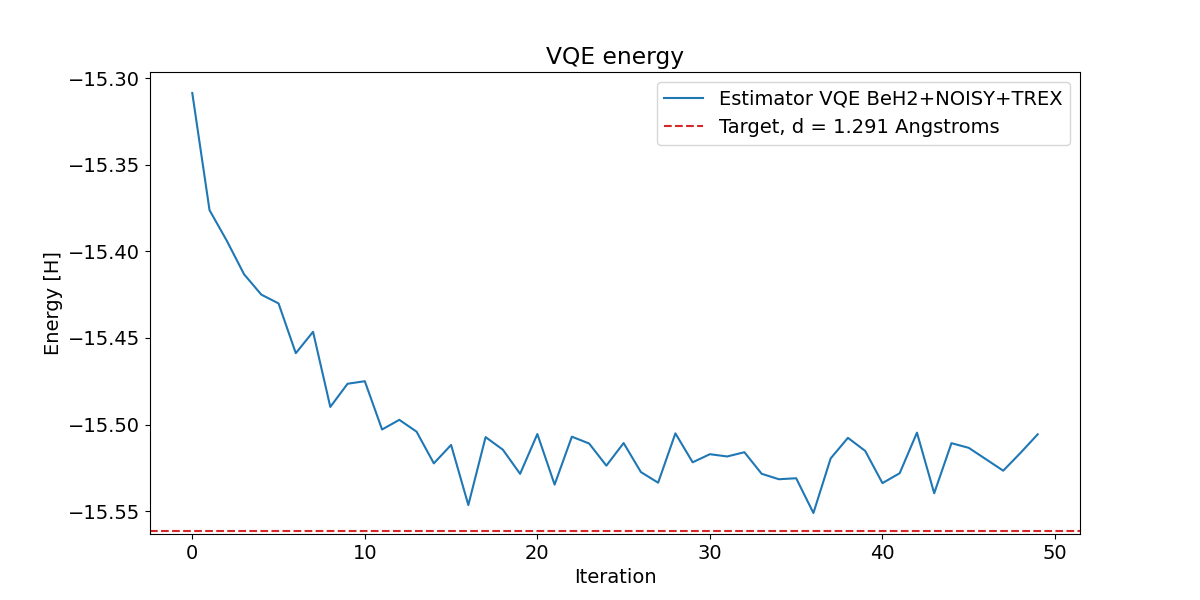

In [ ]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(E, label="Estimator VQE BeH2+NOISY+TREX")
plt.axhline(y=Target_E, color="tab:red", ls="--", label="Target, d = 1.291 Angstroms")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

Additionally we have error mitigated results from the real backend ibmq_lima using TREX and ZNE. While TREX results show monotonic convergence to the ground state, we show ZNE results.

In [ ]:
backend = 'ibmq_lima'

In [ ]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='qhack-event/main/level-2-team-1',
)

In [ ]:
options_with_em = Options(resilience_level=2 # You may change the value here. resilience_level = 1 will activate TREX
)

In [ ]:
%%time
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 1024

# Define convergence list
convergence = []

# Keep track of jobs (Do-not-modify)
job_list = []

# Initialize estimator object
#estimator = Estimator()# Enter your code here

# Define evaluate_expectation function
def evaluate_expectation(x):
    x = list(x)
    
    # Define estimator run parameters
    #### enter your code below ####



    with Session(service=service, backend=backend):
      estimator = Estimator(options=options_with_em)
      job = estimator.run(circuits=[ansatz], parameter_values=[x],observables=qubit_op_parity).result()
      results = job.values[0]
      job_list.append(job)


    # Pass results back to callback function
    return np.real(results)



# Call back function
def callback(x,fx,ax,tx,nx):
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
    convergence.append(evaluate_expectation(fx))

np.random.seed(10)

# Define initial point. We shall define a random point here based on the number of parameters in our ansatz
initial_point = np.random.random(ansatz.num_parameters)

#### enter your code below ####
# Define optimizer and pass callback function
optimizer = SPSA(maxiter = 50, callback=callback) # ----------- Enter your code here

# Define minimize function
result =  optimizer.minimize(evaluate_expectation, x0=initial_point) # ----------- Enter your code here

In [ ]:
Energy_H_t = []
for i in range(len(convergence)):
    sol = MinimumEigensolverResult()
    sol.eigenvalue = convergence[i]
    sol = problem_reduced.interpret(sol).total_energies[0]
    Energy_H_t.append(sol)
print("Computed Energy:", Energy_H_t[-1])

In [ ]:
#the list below is obtained from running the above code using ibmq_lima backend with ZNE.

Energy = [(-15.299725496726987+0j), (-15.404457371901044+0j), (-15.432048634488877+0j), (-15.479413567324093+0j), (-15.484154453097942+0j), (-15.498274731551897+0j), (-15.502134849652316+0j), (-15.501013354303835+0j), (-15.519383560872486+0j), (-15.525552730938573+0j), (-15.554337105185438+0j), (-15.554400483338556+0j), (-15.551891864562178+0j), (-15.545635016923596+0j), (-15.555698525879142+0j), (-15.551595355187027+0j), (-15.550354849219326+0j), (-15.551810351294685+0j), (-15.551651191275324+0j), (-15.54715839405482+0j), (-15.551579926022692+0j), (-15.549270670410346+0j), (-15.550742270040319+0j), (-15.558344780907598+0j), (-15.549046655882846+0j), (-15.554513011088916+0j), (-15.552365255003002+0j), (-15.552115439722515+0j), (-15.552561179281044+0j), (-15.548556478987896+0j), (-15.548150337736507+0j), (-15.550477227254524+0j), (-15.552545202356784+0j), (-15.549357297389344+0j), (-15.553080711408695+0j), (-15.553468837096995+0j), (-15.550786010522367+0j), (-15.550639970088818+0j), (-15.551100054992032+0j), (-15.551329759565471+0j), (-15.547600770146323+0j), (-15.5489985182846+0j), (-15.55645182159987+0j), (-15.55738365191599+0j), (-15.551482890586493+0j), (-15.551267266507073+0j), (-15.553622111797393+0j), (-15.553782805606561+0j), (-15.55176306113025+0j), (-15.550018243753359+0j)]

Target_E = -15.561651427447183

E = []
for i in range(len(Energy)):
    E.append(np.real(Energy[i]))


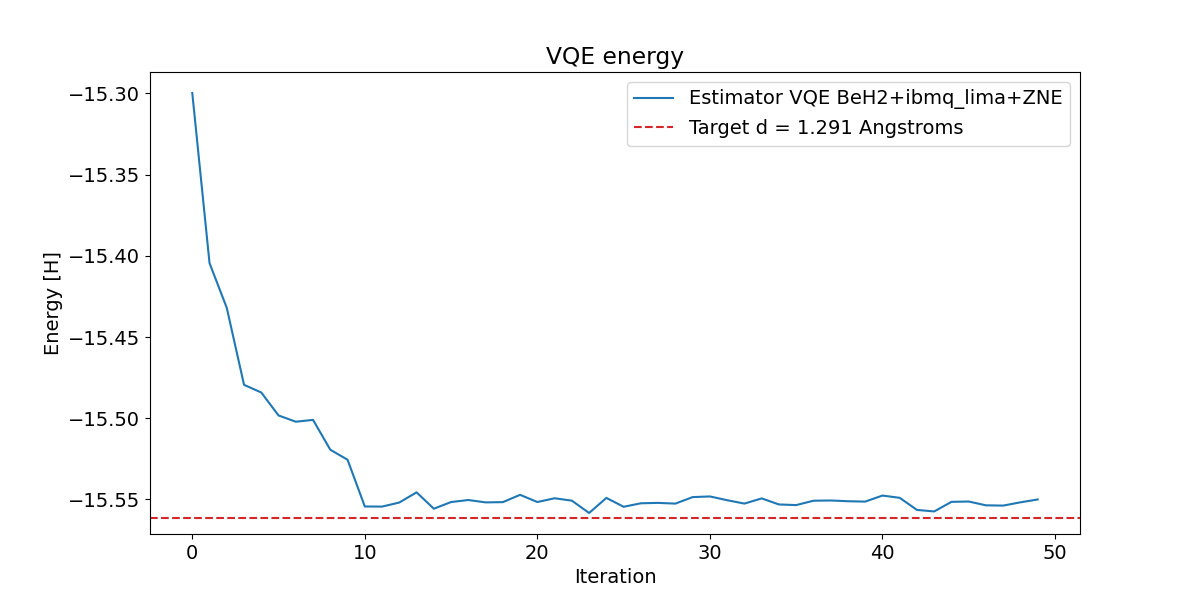

In [ ]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(E, label="Estimator VQE BeH2+ibmq_lima+ZNE")
plt.axhline(y=Target_E, color="tab:red", ls="--", label="Target d = 1.291 Angstroms")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

The results show that the qiskit runtime error mitigation works quite well.

We also use entanglement forging from circuit knitting toolbox to reduce the complexity of the problem while sacrificing chemical accuracy.

In [ ]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
molecule = Molecule(
    geometry=[
        ("Be",[0.0,0.0,0.0]),
        ("H", [0.0, 0.0, -1.3]),
        ("H", [0.0, 0.0, 1.3]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")


transformer = ActiveSpaceTransformer(
    num_electrons=6, # Number of electrons in our active space
    num_molecular_orbitals=2, # Number of orbitals in our active space
)
problem = ElectronicStructureProblem(
        driver,
        [transformer])

In [ ]:
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal

ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(2, [], "cry", [[0, 1], [1,0]], reps=1),
    bitstrings_u=[(0,1),(1,0)],
)

ansatz.circuit_u.draw()

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 4

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 2000}), Options(execution={"shots":2000}),Options(execution={"shots":1000})]
import numpy as np

In [ ]:
import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

optimizer = COBYLA(maxiter=50,tol = 1e-5)

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
    options=options,
    initial_point=[0.0, np.pi / 2],
)

In [ ]:
%%capture

results = solver.solve(problem)

The following results are obtained from running the above code. We also explored applying entanglement forging differently by a different choice of used bitstrings. The procedure is explained here. https://github.com/qiskit-community/prototype-entanglement-forging/blob/main/docs/3-explanatory_material/explanatory_material.md#picking-the-bitstrings

In [ ]:
eigenvalue = [-15.067677961867169, -14.43349358705019, -16.850469941463, -17.35366210680921, -15.923394623984477, -17.39183988919921, -15.819941135220622, -17.66749851343628, -16.604922689851417, -17.666004725250048, -16.603020233190847, -17.29859516235202, -17.72566408267279, -17.69888982692018, -17.725690220806747, -17.69877309532289, -17.707285219181852, -17.72692685156067, -17.72285154687804, -17.72692548497306, -17.722851428629223, -17.725553090234015, -17.727115720551243, -17.726972567291043, -17.72711573111239, -17.72697242358583, -17.72706287631097, -17.727111031352962, -17.727110299209098, -17.7271157340197, -17.72711597275354, -17.727114147285853, -17.72711598580272, -17.72711650046225, -17.727115718768687, -17.72711627160566, -17.727116501379225, -17.727116401603, -17.72711642982655, -17.727116506819804, -17.72711649203592, -17.727116506782636, -17.727116492007838, -17.727116501944796, -17.72711650735905, -17.72711650663199, -17.727116507358662, -17.727116506631813, -17.727116507025464]


Energy:


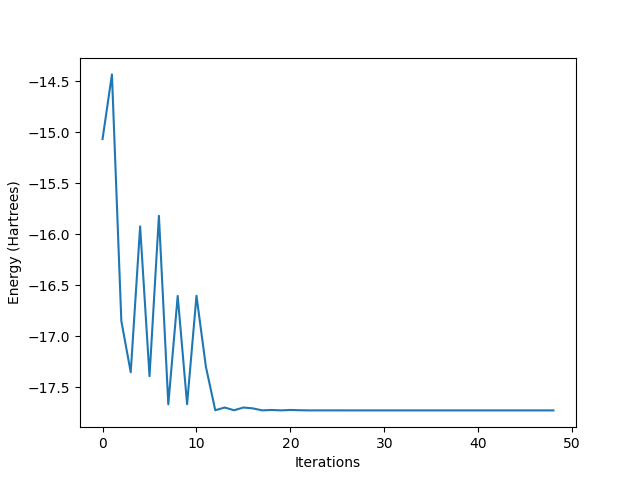

In [ ]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot(eigenvalue)
plt.xlabel("Iterations")
plt.ylabel("Energy (Hartrees)")
plt.show()


We also used orbital freezing through the following from IBM, problem = ElectronicStructureProblem(driver,[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[-3,-2, -1])]) where we checked that excluding the orbitals we listed did not influence the chemical accuracy as much as excluding more orbitals. 
